In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(130298)

In [2]:
%pwd

'/Users/annachiararossi/Documents/Healthcare data/heart-failure-project'

# Dataset importing and NAs identification

Looking at the variables one at a time, in the notebook "1_Data preprocessing and cleaning", we highlighted some values which were likely miswritten. We identified the value 'Unknown' to be recognized as a missing value and same for all patients for which a value of 0 was reported, where it is not physically possible. Also some unlikely values in weight and height will be substituted by missing values, as they represent biased information. For more detailed explanations on these choices, see the notebook previously cited.

In [3]:
sentinels={'DestinationDischarge':['Unknown'], 'occupation':['NA'], 
          'pulse':[0],'respiration':[0], 'systolic.blood.pressure':[0],
          'diastolic.blood.pressure':[0], 'map':[0], 'weight':[0,8],
           'height':[0.35,0.48,0.6], 'left.ventricular.end.diastolic.diameter.LV':[0]
          }

df = pd.read_csv('dat.csv', na_values=sentinels)
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.set_index('inpatient.number', inplace = True)
df.head()

,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,respiration,...,body.temperature.blood.gas,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat
inpatient.number,,,,,,,,,,,,,,,,,,,,,
857781,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87.0,19.0,...,37.0,97.0,93.0,95.9,17.8,1.14,125.0,15,11,"(69,79]"
743087,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.8,95.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,8,"(69,79]"
866418,Home,Cardiology,NonEmergency,farmer,Cardiology,2,Male,36.5,98.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(59,69]"
775928,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.0,73.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,11,"(69,79]"
810128,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,35.0,88.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(69,79]"


We remove the columns with more than 50% of missing values, as no gain would come if we would impute their values due to the quantity.

In [4]:
missing_perc = df.isnull().sum()/len(df)
columns_missing = df.columns[np.where(missing_perc>0.5)]
print(f"number of columns dropped: {len(columns_missing)}")
data = df.copy()
data.drop(columns = list(columns_missing), inplace = True)
print(f"Current number of features: {data.shape[1]}")

number of columns dropped: 43
Current number of features: 122


# Analysis of the variance of the features
We want to know if some features have 0 (or almost 0) variance, to exclude them from the models apriori. Indeed, a variable which has no dispersion in its values, cannot be used to explain the variability in another variable. 
In the previous histplots, we realized that some of the 0/1 categorical variables have very few cases of one of the two categories. The names of these are stored in the list "col_to_exclude" and with a variance analysis we will see that their variance is almost 0. We choose $\tau$ = 0.01 as a threshold.

In [5]:
variance = data.var()
col_to_exclude = list(variance[variance < 0.01].index)
col_to_exclude

['height',
 'connective.tissue.disease',
 'hemiplegia',
 'leukemia',
 'malignant.lymphoma',
 'AIDS',
 'acute.renal.failure',
 'monocyte.ratio',
 'hematocrit',
 'basophil.ratio',
 'basophil.count',
 'eosinophil.ratio',
 'platelet.hematocrit',
 'hydroxybutyrate.dehydrogenase.to.lactate.dehydrogenase']

In [6]:
data.drop(columns = col_to_exclude, inplace = True)
print(f"Current number of features: {data.shape[1]}")

Current number of features: 108


# Categorical Variables

The variable 'visit.times' it's ordinal, and it will be kept as such in the one-hot encoding since its values are numerical. The same goes for 'eye.opening','verbal.response', 'movement', 'GCS' and 'CCI.score', whose meaning is explained in the file "1_Data preprocessing and cleaning".

In [7]:
data['GCS'][data['GCS']<=8].value_counts().sum()/data['GCS'].shape[0] 

0.009462151394422311

Also notice that we will distinguish categorical and binary vairables, as the latter do not need one-hot encoding. This will be an advantage since less columns will be required.

In [9]:
categorical_columns = ['DestinationDischarge','admission.ward','admission.way','occupation','discharge.department',
                       'type.of.heart.failure', 'NYHA.cardiac.function.classification', 'Killip.grade',
                       'consciousness', 'outcome.during.hospitalization','ageCat']

ordinal_columns = ['visit.times', 'CCI.score', 'eye.opening','verbal.response', 'movement', 'GCS']

not_continuous = categorical_columns.copy()

binary_columns = ['gender', 'myocardial.infarction', 'congestive.heart.failure', 'peripheral.vascular.disease',
                  'cerebrovascular.disease', 'dementia', 'Chronic.obstructive.pulmonary.disease',
                  'peptic.ulcer.disease', 'diabetes', 'moderate.to.severe.chronic.kidney.disease',
                  'solid.tumor', 'liver.disease', 'type.II.respiratory.failure', 'oxygen.inhalation', 'death.within.28.days', 're.admission.within.28.days', 
                  'death.within.3.months','re.admission.within.3.months', 'death.within.6.months', 're.admission.within.6.months',
                  'return.to.emergency.department.within.6.months','respiratory.support.']
# NB 'respiratory.support.' is in the binary variables because we will rebin it in 0/1

not_continuous.extend(binary_columns)
not_continuous.extend(ordinal_columns)

In [10]:
# list of the columns with continuous variables, all those not included in the previous
continuous_columns = [col_name for col_name in data.columns if col_name not in not_continuous]

## One-hot encoding

In [11]:
# convert to categorical
cat_data = data[categorical_columns]
cat_data = pd.get_dummies(cat_data)

In [12]:
# not_cat should contain both continuous, binary and ordinal variables
not_cat = continuous_columns.copy()
not_cat.extend(binary_columns)
not_cat.extend(ordinal_columns)

data_new = data[not_cat].join(cat_data)
data_new  # data containing the dummies for algorithms

,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,weight,BMI,fio2,left.ventricular.end.diastolic.diameter.LV,...,outcome.during.hospitalization_Dead,outcome.during.hospitalization_DischargeAgainstOrder,"ageCat_(21,29]","ageCat_(29,39]","ageCat_(39,49]","ageCat_(49,59]","ageCat_(59,69]","ageCat_(69,79]","ageCat_(79,89]","ageCat_(89,110]"
inpatient.number,,,,,,,,,,,,,,,,,,,,,
857781,36.7,87.0,19.0,102.0,64.0,76.666667,50.0,18.590125,33,NaN,...,0,0,0,0,0,0,0,1,0,0
743087,36.8,95.0,18.0,150.0,70.0,96.666667,51.0,19.195303,33,40.0,...,0,0,0,0,0,0,0,1,0,0
866418,36.5,98.0,18.0,102.0,67.0,78.666667,70.0,24.221453,33,46.0,...,0,0,0,0,0,0,1,0,0,0
775928,36.0,73.0,19.0,110.0,74.0,86.000000,65.0,22.491349,33,NaN,...,0,0,0,0,0,0,0,1,0,0
810128,35.0,88.0,19.0,134.0,62.0,86.000000,76.0,31.633715,33,64.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740689,36.1,117.0,22.0,120.0,80.0,93.333333,35.0,15.555556,33,NaN,...,0,1,0,0,0,0,0,0,1,0
734280,36.3,70.0,21.0,120.0,86.0,97.333333,50.0,20.811655,29,NaN,...,0,0,0,0,0,0,0,0,1,0
781004,36.8,113.0,19.0,135.0,100.0,111.666667,75.0,25.951557,33,NaN,...,0,0,0,0,1,0,0,0,0,0


## Binary variables to {0,1}

In [13]:
data['type.II.respiratory.failure'].value_counts()

NonTypeII    1894
TypeII        114
Name: type.II.respiratory.failure, dtype: int64

In [14]:
data_new['type.II.respiratory.failure'] = [1 if elem=='TypeII' else 0 for elem in data['type.II.respiratory.failure']]

In [15]:
data['gender'].value_counts()

Female    1163
Male       845
Name: gender, dtype: int64

In [16]:
data_new['gender'] = [1 if elem=='Male' else 0 for elem in data['gender']]

In [17]:
data['oxygen.inhalation'].value_counts()

OxygenTherapy    1898
AmbientAir        110
Name: oxygen.inhalation, dtype: int64

In [18]:
data_new['oxygen.inhalation'] = [1 if elem=='AmbientAir' else 0 for elem in data['oxygen.inhalation']]

In [29]:
# Convert CCI.score to int -- doesn't work
# data_new["CCI.score"].loc[data_new["CCI.score"].notnull()] = data["CCI.score"].loc[data["CCI.score"].notnull()].astype(int).values

## Rebinning some categorical variables

In [33]:
# 0: None
# 1: mandatory ventilation (intermittent or not)
data['respiratory.support.'].value_counts()

None    1966
IMV       25
NIMV      17
Name: respiratory.support., dtype: int64

In [34]:
new_col = data['respiratory.support.'].copy()
new_col[new_col == 'None'] = 0
new_col[new_col == 'IMV'] = 1
new_col[new_col == 'NIMV'] = 1

Now we substitute the previous column with these values.

In [35]:
data_new['respiratory.support.'] = new_col

# Continuous variables and correlation analysis

We will plot the correlation matrix just to have an idea of the possible groups of features that have a high (positive or negative) correlation. But clearly there are too many continuous variables to get a clear understading from this.

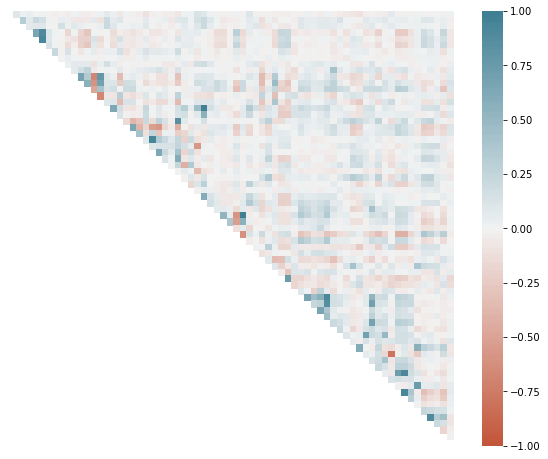

In [36]:
plt.figure(figsize=(10,8))
cor_matrix = data[continuous_columns].corr()

mask = np.tril(np.ones_like(cor_matrix, dtype=bool))
sns.heatmap(cor_matrix, mask = mask, xticklabels = False, yticklabels = False, vmin=-1, vmax=1, center = 0,
            cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

In [37]:
highly_corr_features = np.where(np.abs(cor_matrix) > 0.9)
coupled_features = zip(highly_corr_features[0],highly_corr_features[1])

ls = []
ls_names = []
# list of tuples of correlated features -- recover the names from correlation matrix
for elem1,elem2 in coupled_features:
    # exclude the couples with the same feature (corr = 1) and the couple already present in the list
    if elem1 != elem2 and (elem2,elem1) not in ls:
        ls.append((elem1,elem2))
        ls_names.append((cor_matrix.iloc[:,elem1].name,cor_matrix.iloc[:,elem2].name))

In [38]:
ls

[(4, 5), (15, 30), (20, 22), (32, 36), (45, 49), (57, 61), (60, 61)]

In [39]:
ls_names

[('diastolic.blood.pressure', 'map'),
 ('white.blood.cell', 'neutrophil.count'),
 ('mean.corpuscular.volume', 'mean.hemoglobin.volume'),
 ('international.normalized.ratio', 'prothrombin.time.ratio'),
 ('hydroxybutyrate.dehydrogenase', 'lactate.dehydrogenase'),
 ('indirect.bilirubin', 'total.bilirubin'),
 ('direct.bilirubin', 'total.bilirubin')]

### Analysis of the highly correlated features:

In [42]:
plt.figure(figsize=(10,8))
cor_matrix = data.loc[:,['diastolic.blood.pressure', 'map']].corr()
cor_matrix

,diastolic.blood.pressure,map
diastolic.blood.pressure,1.000000,0.922416
map,0.922416,1.000000


<Figure size 720x576 with 0 Axes>

In [43]:
col_to_drop = []
col_to_drop = ['diastolic.blood.pressure']

I'd keep the feature 'map' (Mean Arterial Pressure) since it synthesises the systolic and dyastolic blood pressures.

In [44]:
cor_matrix = data.loc[:,['white.blood.cell', 'neutrophil.count']].corr()
cor_matrix

,white.blood.cell,neutrophil.count
white.blood.cell,1.000000,0.975485
neutrophil.count,0.975485,1.000000


In [45]:
col_to_drop.append('neutrophil.count')

We take 'white.blood.cell' since we have already a variable that rapresent the neutrophil rate.

In [46]:
cor_matrix = data.loc[:,['mean.corpuscular.volume', 'mean.hemoglobin.volume']].corr()
cor_matrix

,mean.corpuscular.volume,mean.hemoglobin.volume
mean.corpuscular.volume,1.000000,0.940614
mean.hemoglobin.volume,0.940614,1.000000


In [47]:
col_to_drop.append('mean.hemoglobin.volume')

We take 'mean.corpuscular.volume' since have better distribution as we can see in the file 1_Data processing and cleaning

In [48]:
cor_matrix = data.loc[:,['international.normalized.ratio', 'prothrombin.time.ratio']].corr()
cor_matrix

,international.normalized.ratio,prothrombin.time.ratio
international.normalized.ratio,1.000000,0.997028
prothrombin.time.ratio,0.997028,1.000000


In [49]:
col_to_drop.append('international.normalized.ratio')

We take 'prothrombin.time.ratio' since the 'international.normalized.ratio' is calculated from the other one.

In [50]:
cor_matrix = data.loc[:,['hydroxybutyrate.dehydrogenase', 'lactate.dehydrogenase']].corr()
cor_matrix

,hydroxybutyrate.dehydrogenase,lactate.dehydrogenase
hydroxybutyrate.dehydrogenase,1.000000,0.920142
lactate.dehydrogenase,0.920142,1.000000


In [51]:
col_to_drop.append('hydroxybutyrate.dehydrogenase')

La 3-idrossibutirrato deidrogenasi è un enzima appartenente alla classe delle ossidoreduttasi, che catalizza la seguente reazione:

(D)-3-idrossibutanoato + NAD+ ⇄ acetoacetato + NADH + H+

La L-lattato deidrogenasi (o LDH) è un enzima, appartenente alla classe delle ossidoreduttasi, che catalizza la seguente reazione:

(L)-lattato + NAD+ ⇄ piruvato + NADH + H+

We notice that these two enzymes catalyze indeed very similar chemical reactions, so we can explain ourselves the big correlation between the two.

In [52]:
cor_matrix = data.loc[:,['indirect.bilirubin', 'total.bilirubin']].corr()
cor_matrix

,indirect.bilirubin,total.bilirubin
indirect.bilirubin,1.000000,0.927824
total.bilirubin,0.927824,1.000000


In [53]:
cor_matrix = data.loc[:,['direct.bilirubin', 'total.bilirubin']].corr()
cor_matrix

,direct.bilirubin,total.bilirubin
direct.bilirubin,1.000000,0.932437
total.bilirubin,0.932437,1.000000


In [54]:
col_to_drop.append('direct.bilirubin')
col_to_drop.append('indirect.bilirubin')

We take the 'total.bilirubin' since is the sum of the indirect and direct bilirubin.

#### We drop the column that are correlated

In [55]:
data1 = data_new.copy()
data_reduced = data1.drop(col_to_drop, axis=1)
print(f"Current number of features: {data_reduced.shape[1]}")

Current number of features: 133


In [56]:
data_reduced.to_csv('data_cleaned.csv')